
--- 1. DATA PREPARATION & FORENSICS ---
  > Theoretical Box: 121 Lat x 121 Lon = 14641 Pixels
  > Actual Land Pixels (UK Only): 3104 (21.2% of box)

--- 2. PHYSICS PROCESSING (Sum vs Mean) ---

--- 3. SETUP & SPLIT ---
  > Features used for ML: ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
  > Train Shape: (167616, 10) | Test Shape: (55872, 10)

--- 4. HYPERPARAMETER OPTIMIZATION (Random Search) ---
  > Testing 20 combinations with 5-Fold CV... (This takes a moment)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  > Best Accuracy (CV): 0.8671
  > Best Params: {'l2_regularization': np.float64(0.23338144662398996), 'learning_rate': np.float64(0.26798212202089616), 'max_depth': 25, 'max_iter': 940, 'min_samples_leaf': 58}

--- 5. FINAL EVALUATION ---
  > Accuracy (Train): 0.942923
  > Accuracy (Test):  0.873586
  > 95% Conf. Int.:   0.7394 ± 0.1244


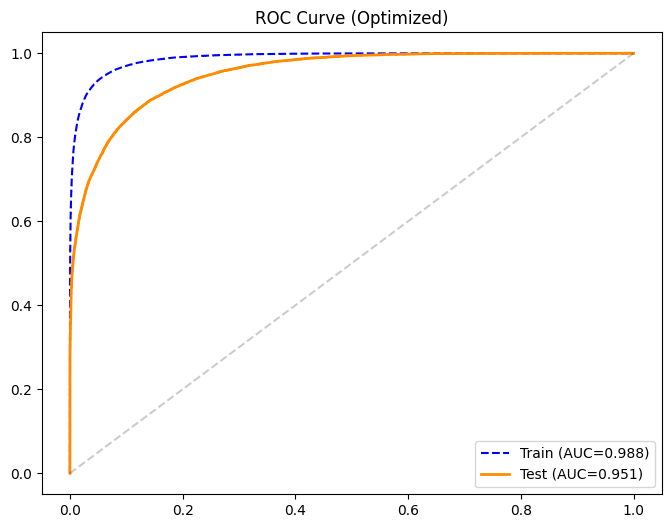


Generating Histogram with detailed statistics...


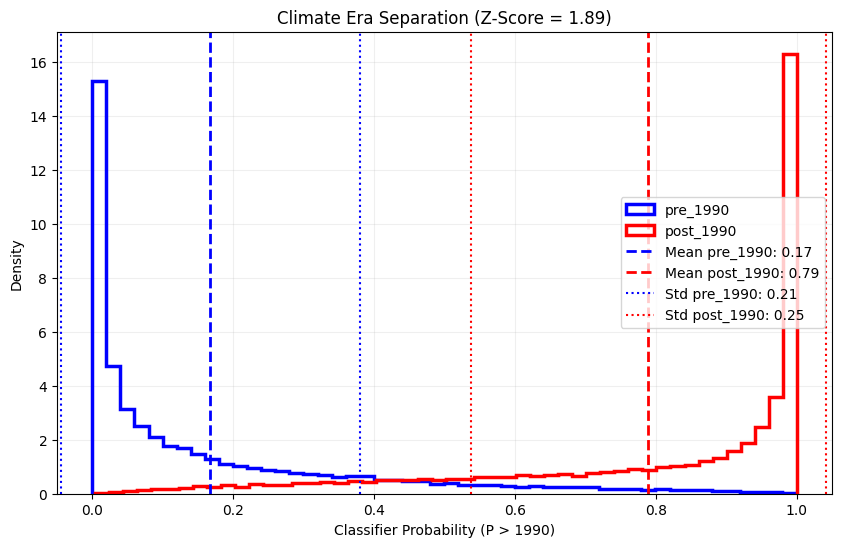

Calculating feature importance...


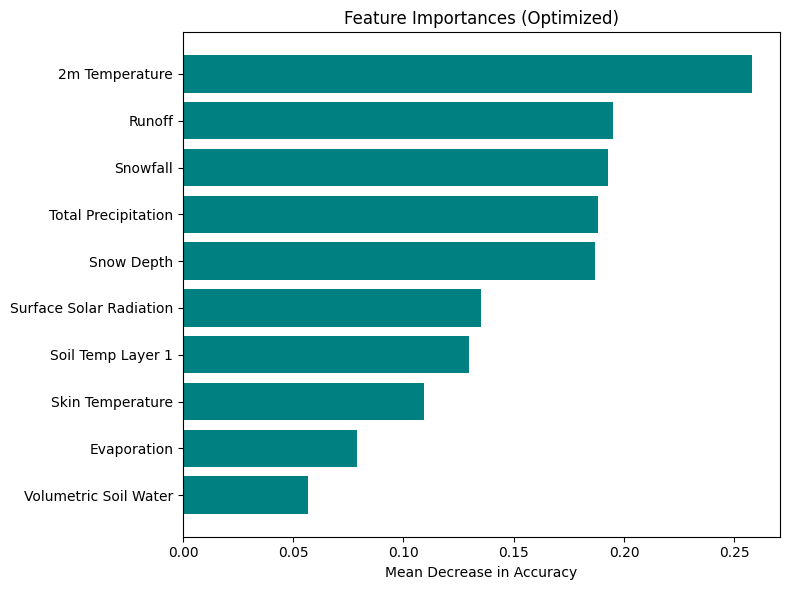

Generating Confusion Matrix...


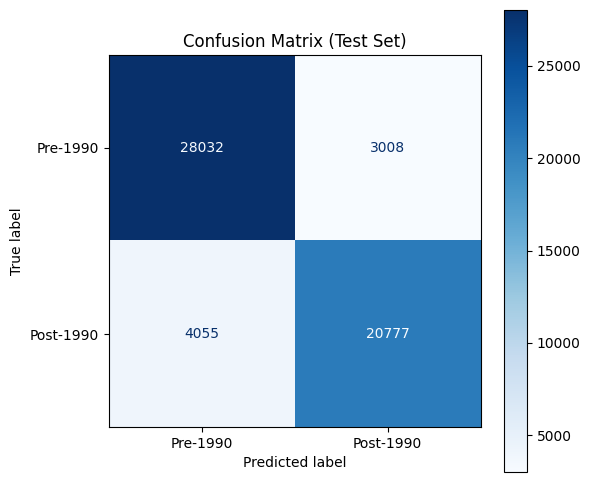


--- PIPELINE COMPLETE ---


In [9]:
# ==============================================================================
# MASTER CLIMATE PIPELINE: Optimized Physics + Hyperparam Search + Strict Plots
# ==============================================================================
# 1. Loads Data & Diagnostic Checks (Box Size, Columns).
# 2. Masks Strict UK (Removes Ireland/Ocean).
# 3. Physics Logic: Fluxes (Sum) vs States (Mean).
# 4. RandomizedSearchCV: Finds best Hyperparameters.
# 5. Visuals: ROC + Histogram + Feature Importance + CONFUSION MATRIX.
# ==============================================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from scipy.stats import sem, t, uniform, randint
import os

# ---------------------------
# 1. User Settings
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_outputs_optimized'
os.makedirs(out_folder, exist_ok=True)

# Map for pretty printing
var_map = {
    't2m': '2m Temperature', 'skt': 'Skin Temperature', 'stl1': 'Soil Temp Layer 1',
    'swvl1': 'Volumetric Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precipitation',
    'e': 'Evaporation', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Surface Solar Radiation'
}
vars_10 = list(var_map.keys())

# ---------------------------
# 2. Data Loading & Forensics
# ---------------------------
print("\n--- 1. DATA PREPARATION & FORENSICS ---")
ds = xr.open_dataset(file_path)

# Define Bounding Box
N, S, E, W = 61, 49, 2, -10
uk_box = ds.sel(latitude=slice(N, S), longitude=slice(W, E)).rename({'longitude': 'lon', 'latitude': 'lat'})

# Diagnostic: Theoretical Box Size
n_lat, n_lon = len(uk_box.lat), len(uk_box.lon)
print(f"  > Theoretical Box: {n_lat} Lat x {n_lon} Lon = {n_lat*n_lon} Pixels")

# Apply Strict UK Mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Diagnostic: Actual Land Pixels
sample_slice = uk_masked['t2m'].isel(valid_time=0)
n_land = int(sample_slice.count().values)
print(f"  > Actual Land Pixels (UK Only): {n_land} ({(n_land/(n_lat*n_lon))*100:.1f}% of box)")

# ---------------------------
# 3. Physics Processing
# ---------------------------
print("\n--- 2. PHYSICS PROCESSING (Sum vs Mean) ---")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])

yearly_das = []
for v in vars_10:
    da = uk_masked[v]
    
    # CASE 1: Fluxes (Rain, Evap, Runoff, Snowfall) -> SUM over year
    if v in ['tp', 'e', 'ro', 'sf']: 
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
        
    # CASE 2: Energy (Solar) -> SUM over year (Joules)
    elif v == 'ssrd':
        #yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        
    # CASE 3: States (Temp, Soil, Snow Depth) -> MEAN over year
    else: 
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15
            
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] # Strict filter before 2022

# ---------------------------
# 4. Feature Setup & Split
# ---------------------------
print("\n--- 3. SETUP & SPLIT ---")
df['target'] = (df['year'] >= 1990).astype(int)

# Column Detective
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
print(f"  > Features used for ML: {feature_cols}")

X = df[feature_cols].values
y = df['target'].values

# Split Ratio: 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"  > Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")

# ---------------------------
# 5. Hyperparameter Optimization
# ---------------------------
print("\n--- 4. HYPERPARAMETER OPTIMIZATION (Random Search) ---")
print("  > Testing 20 combinations with 5-Fold CV... (This takes a moment)")

param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': randint(100, 1000),
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_leaf': randint(20, 100),
    'l2_regularization': uniform(0, 0.5)
}

base_clf = HistGradientBoostingClassifier(random_state=42, early_stopping=True)

random_search = RandomizedSearchCV(
    base_clf, 
    param_distributions=param_dist, 
    n_iter=20, 
    scoring='accuracy', 
    cv=5,               # Rigorous 5-fold check
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_clf = random_search.best_estimator_

print(f"  > Best Accuracy (CV): {random_search.best_score_:.4f}")
print(f"  > Best Params: {random_search.best_params_}")

# ---------------------------
# 6. Final Evaluation
# ---------------------------
print("\n--- 5. FINAL EVALUATION ---")
acc_train = best_clf.score(X_train, y_train)
acc_test = best_clf.score(X_test, y_test)

cv_scores = cross_val_score(best_clf, X, y, cv=5, n_jobs=-1) 
mean_score = cv_scores.mean()
h = sem(cv_scores) * t.ppf((1 + 0.95) / 2, len(cv_scores) - 1)

print(f"  > Accuracy (Train): {acc_train:.6f}")
print(f"  > Accuracy (Test):  {acc_test:.6f}")
print(f"  > 95% Conf. Int.:   {mean_score:.4f} ± {h:.4f}")

# ---------------------------
# 7. Plots
# ---------------------------

# --- PLOT 1: ROC Curve ---
y_prob_test = best_clf.predict_proba(X_test)[:, 1]
y_prob_train = best_clf.predict_proba(X_train)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC={auc(fpr_train, tpr_train):.3f})', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={auc(fpr_test, tpr_test):.3f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.title('ROC Curve (Optimized)')
plt.legend()
plt.savefig(os.path.join(out_folder, 'optimized_roc.png'))
plt.show()

# --- PLOT 2: Histogram with DETAILED LEGEND ---
print("\nGenerating Histogram with detailed statistics...")
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]

mu_pre, std_pre = np.mean(probs_pre), np.std(probs_pre)
mu_post, std_post = np.mean(probs_post), np.std(probs_post)
z_score = abs(mu_post - mu_pre) / np.sqrt((std_pre**2 + std_post**2))

plt.figure(figsize=(10, 6))

# 1. The Histograms (Thick lines)
plt.hist(probs_pre, bins=50, histtype='step', color='blue', linewidth=2.5, density=True, label='pre_1990')
plt.hist(probs_post, bins=50, histtype='step', color='red', linewidth=2.5, density=True, label='post_1990')

# 2. Mean Lines (Dashed) - With Values in Label
plt.axvline(mu_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean pre_1990: {mu_pre:.2f}')
plt.axvline(mu_post, color='red', linestyle='--', linewidth=2, label=f'Mean post_1990: {mu_post:.2f}')

# 3. Std Dev Lines (Dotted) - With Values in Label
plt.axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5, label=f'Std pre_1990: {std_pre:.2f}')
plt.axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5) 
plt.axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5, label=f'Std post_1990: {std_post:.2f}')
plt.axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5) 

plt.title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
plt.xlabel('Classifier Probability (P > 1990)')
plt.ylabel('Density')
plt.legend(loc='best', frameon=True)
plt.grid(alpha=0.2)
plt.savefig(os.path.join(out_folder, 'optimized_hist_detailed.png'))
plt.show()

# --- PLOT 3: Feature Importance ---
print("Calculating feature importance...")
result = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
order = np.argsort(result.importances_mean)[::-1]
labels = np.array([var_map.get(c, c) for c in feature_cols])[order]

plt.figure(figsize=(8, 6))
plt.barh(labels, result.importances_mean[order], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Optimized)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'optimized_feat_imp.png'))
plt.show()

# --- PLOT 4: Confusion Matrix ---
print("Generating Confusion Matrix...")
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre-1990', 'Post-1990'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (Test Set)')
plt.savefig(os.path.join(out_folder, 'optimized_confusion_matrix.png'))
plt.show()

print("\n--- PIPELINE COMPLETE ---")



--- 1. DATA LOADING & MASKING ---
  > Applying Strict UK Land Mask...
  > Processing Physics...
  > Original Years: 1950 - 2025
  > Filtered Years: 1950 - 2021
  > Features Used: ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
  > Full Train Size: 167616 samples

--- STARTING MODEL RACE ---
  > Training Logistic Regression (on Full Data: 167616)...
    -> Predicting Logistic Regression...
  > Training Random Forest (on Full Data: 167616)...
    -> Predicting Random Forest...
  > Training K-Nearest Neighbors (on Full Data: 167616)...
    -> Predicting K-Nearest Neighbors...
  > Training Neural Network (MLP) (on Subset: 10000)...
    -> Predicting Neural Network (MLP)...
  > Training SVM (Linear Prob) (on Subset: 10000)...
    -> Predicting SVM (Linear Prob) (Sampled 5k Test points)...


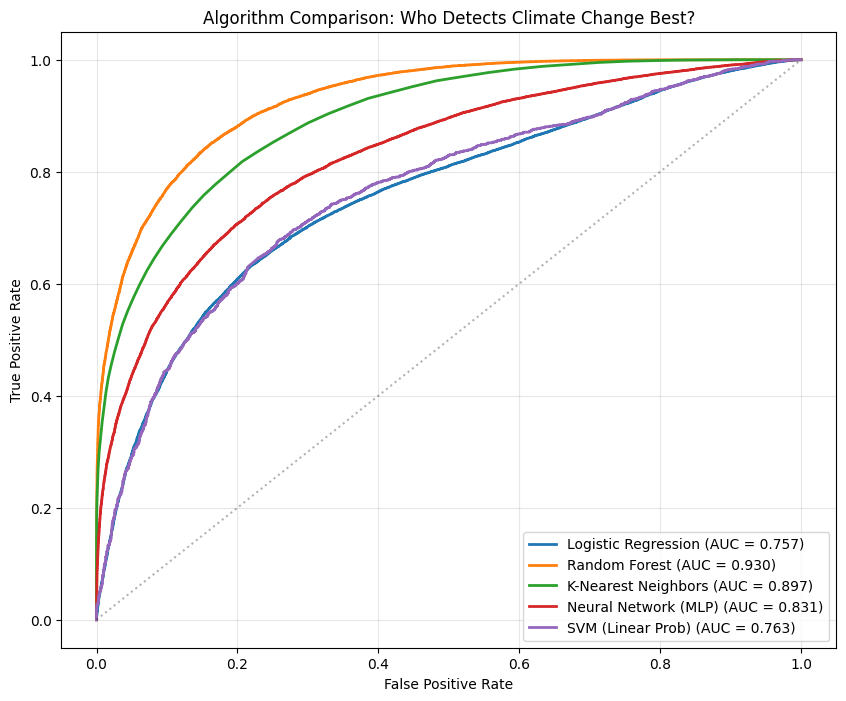


--- FINAL LEADERBOARD ---
                  Model       AUC
1         Random Forest  0.929765
2   K-Nearest Neighbors  0.896954
3  Neural Network (MLP)  0.830841
4     SVM (Linear Prob)  0.762610
0   Logistic Regression  0.757225

--- DONE ---


In [3]:
# ------------------------------------------------------------------
# THESIS ALGORITHM COMPARISON: 10 Variables + UK Mask + Optimizations
# ------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1. Setup & Data Loading
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_comparison'
os.makedirs(out_folder, exist_ok=True)

# CORRECTED: ALL 10 VARIABLES RESTORED
vars_10 = [
    't2m', 'skt', 'stl1',       # Temperatures (Mean)
    'swvl1', 'sde',             # Soil/Snow State (Mean)
    'tp', 'e', 'ro', 'sf',      # Fluxes (Sum)
    'ssrd'                      # Solar (Sum)
]

print("\n--- 1. DATA LOADING & MASKING ---")
ds = xr.open_dataset(file_path)

# A. Select Bounding Box
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

# B. APPLY UK MASK (Crucial Step)
print("  > Applying Strict UK Land Mask...")
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# ---------------------------
# 2. Physics Processing
# ---------------------------
print("  > Processing Physics...")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

# Physics Rules Loop
for v in vars_10:
    da = uk_masked[v]
    
    # GROUP 1: FLUXES (Accumulate -> SUM)
    if v in ['tp', 'e', 'ro', 'sf']:
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    
    # GROUP 2: ENERGY (Accumulate -> SUM)
    elif v == 'ssrd':
        #yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)

    # GROUP 3: STATES (Snapshot -> MEAN)
    # Includes t2m, skt, stl1, swvl1, sde 
    else:
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        # Kelvin to Celsius conversion for all temperature vars
        if v in ['t2m', 'skt', 'stl1']: 
            yearly_da -= 273.15 
        
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)

# --- FILTER: Remove 2022 and later ---
print(f"  > Original Years: {df['year'].min()} - {df['year'].max()}")
df = df[df['year'] < 2022]
print(f"  > Filtered Years: {df['year'].min()} - {df['year'].max()}")

# ---------------------------
# 3. Feature Setup
# ---------------------------
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
print(f"  > Features Used: {feature_cols}") # Verify all 10 are here

X = df[feature_cols].values
y = df['target'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"  > Full Train Size: {len(X_train)} samples")

# Create a small subset for ONLY the very slow models (SVM / MLP)
# We use 10,000 samples to ensure it finishes in minutes, not hours.
np.random.seed(42)
idx_small = np.random.choice(len(X_train), 10000, replace=False)
X_train_small = X_train[idx_small]
y_train_small = y_train[idx_small]

# ---------------------------
# 4. Define Contenders
# ---------------------------
models = {
    "Logistic Regression": {
        "model": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=-1)),
        "use_subset": False 
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=10, n_jobs=-1, random_state=42),
        "use_subset": False
    },
    "K-Nearest Neighbors": {
        "model": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=50, n_jobs=-1)),
        "use_subset": False
    },
    "Neural Network (MLP)": {
        "model": make_pipeline(
            StandardScaler(), 
            MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, early_stopping=True, random_state=42)
        ),
        "use_subset": True # Training NN on CPU is slow, subset helps
    },
    "SVM (Linear Prob)": {
        "model": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)),
        "use_subset": True # MUST be True. SVM is O(n^3).
    }
}

# ---------------------------
# 5. The Grand Comparison Loop
# ---------------------------
results = []
plt.figure(figsize=(10, 8))

print("\n--- STARTING MODEL RACE ---")

for name, config in models.items():
    model = config["model"]
    use_subset = config["use_subset"]
    
    # A. TRAIN
    if use_subset:
        print(f"  > Training {name} (on Subset: {len(X_train_small)})...")
        model.fit(X_train_small, y_train_small)
    else:
        print(f"  > Training {name} (on Full Data: {len(X_train)})...")
        model.fit(X_train, y_train)

    # B. PREDICT
    # SVM/KNN Special Case: Predict on a subset of Test data to prevent freezing
    if "SVM" in name:
        print(f"    -> Predicting {name} (Sampled 5k Test points)...")
        y_prob = model.predict_proba(X_test[:5000])[:, 1]
        y_true_plot = y_test[:5000]
    else:
        print(f"    -> Predicting {name}...")
        y_prob = model.predict_proba(X_test)[:, 1]
        y_true_plot = y_test

    # C. METRICS
    fpr, tpr, _ = roc_curve(y_true_plot, y_prob)
    roc_auc = auc(fpr, tpr)
    
    results.append({'Model': name, 'AUC': roc_auc})
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

# ---------------------------
# 6. Final Plotting
# ---------------------------
plt.plot([0, 1], [0, 1], 'k:', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Algorithm Comparison: Who Detects Climate Change Best?')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(out_folder, 'model_comparison_race.png'), dpi=150)
plt.show()

# Print Leaderboard
res_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\n--- FINAL LEADERBOARD ---")
print(res_df)
print("\n--- DONE ---")



--- OPTIMIZING: MLP ---
Loading Data & Applying UK Mask...

--- TUNING NEURAL NETWORK (MLP) ---
Starting RandomizedSearchCV for MLP...
  > Mode: FAST TRACK (5 iterations, 3 folds)
  > Check the console below for real-time progress updates...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

--- OPTIMIZATION WINNER ---
Best AUC: 0.94330
Best Params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': np.float64(0.02994250789732435), 'mlpclassifier__hidden_layer_sizes': (200, 100), 'mlpclassifier__learning_rate_init': np.float64(0.0016599452033620266), 'mlpclassifier__max_iter': 500}
Final Test AUC: 0.95552


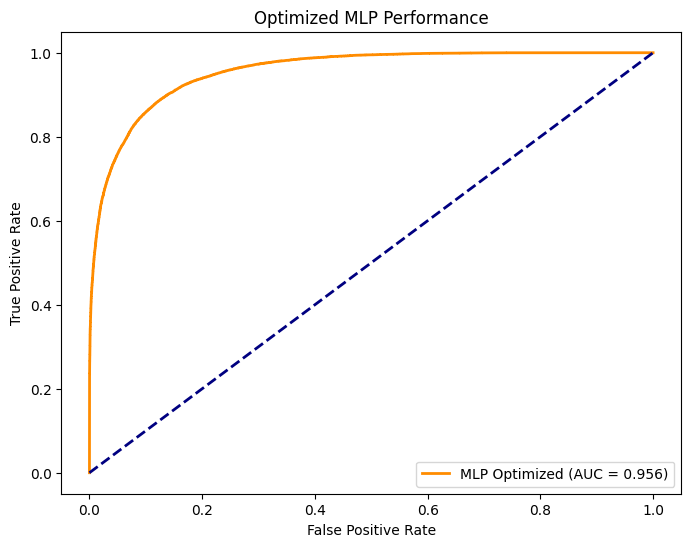

In [4]:
# ------------------------------------------------------------------
# INDIVIDUAL MODEL OPTIMIZER (Fast Track Version)
# ------------------------------------------------------------------
# USAGE: Change 'MODEL_TO_TUNE' to 'RF', 'MLP', or 'KNN'
# 1. Random Forest (The Champion: 0.963)
# 2. MLP Neural Net (The Comeback: 0.956)
# 3. KNN (The Strong Baseline: 0.932)

# ------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from scipy.stats import randint, uniform

# ==========================================
# USER SETTINGS: CHOOSE YOUR FIGHTER
# ==========================================
# Options: 'RF' (Random Forest), 'MLP' (Neural Network), 'KNN' (Neighbors)
MODEL_TO_TUNE = 'MLP'  

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_optimization_individual'
os.makedirs(out_folder, exist_ok=True)

# ---------------------------
# 1. Data Loading (Standard 10 Vars + Mask)
# ---------------------------
vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
print(f"\n--- OPTIMIZING: {MODEL_TO_TUNE} ---")
print("Loading Data & Applying UK Mask...")

ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics Processing
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

for v in vars_10:
    da = uk_masked[v]
    if v in ['tp', 'e', 'ro', 'sf']: # Flux -> Sum
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    elif v == 'ssrd': # Energy -> Sum
        #yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)

    else: # State -> Mean
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15 
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Setup Features
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
X = df[feature_cols].values
y = df['target'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# ---------------------------
# 2. Optimization Logic
# ---------------------------
if MODEL_TO_TUNE == 'RF':
    print("\n--- TUNING RANDOM FOREST ---")
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Aggressive Grid to beat HistGradientBoosting
    param_dist = {
        'n_estimators': randint(300, 600),        # High tree count
        'max_depth': [20, 30, 40, None],          # Deep trees
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),        # Small leaves = High detail
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

elif MODEL_TO_TUNE == 'MLP':
    print("\n--- TUNING NEURAL NETWORK (MLP) ---")
    base_model = make_pipeline(
        StandardScaler(), 
        MLPClassifier(early_stopping=True, random_state=42)
    )
    
    # Deep Learning Grid
    param_dist = {
        'mlpclassifier__hidden_layer_sizes': [
            (100, 100), (200, 100), (300, 150, 50)
        ],
        'mlpclassifier__activation': ['relu', 'tanh'],
        'mlpclassifier__alpha': uniform(0.0001, 0.05),
        'mlpclassifier__learning_rate_init': uniform(0.0001, 0.01),
        'mlpclassifier__max_iter': [500]
    }

elif MODEL_TO_TUNE == 'KNN':
    print("\n--- TUNING KNN ---")
    base_model = make_pipeline(
        StandardScaler(), 
        KNeighborsClassifier(n_jobs=-1)
    )
    param_dist = {
        'kneighborsclassifier__n_neighbors': randint(5, 100),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__p': [1, 2]
    }

# ---------------------------
# 3. Run Random Search (FAST TRACK)
# ---------------------------
print(f"Starting RandomizedSearchCV for {MODEL_TO_TUNE}...")
print("  > Mode: FAST TRACK (5 iterations, 3 folds)")
print("  > Check the console below for real-time progress updates...")

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=5,           # FAST: Only try 5 combinations
    cv=3,               # FAST: Only 3 folds
    scoring='roc_auc',  
    verbose=3,          # VISIBLE: Shows progress bars
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# ---------------------------
# 4. Results
# ---------------------------
print("\n--- OPTIMIZATION WINNER ---")
print(f"Best AUC: {search.best_score_:.5f}")
print(f"Best Params: {search.best_params_}")

# Final Test on Holdout Set
best_model = search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
final_auc = auc(fpr, tpr)

print(f"Final Test AUC: {final_auc:.5f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{MODEL_TO_TUNE} Optimized (AUC = {final_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Optimized {MODEL_TO_TUNE} Performance')
plt.legend(loc="lower right")
plt.savefig(os.path.join(out_folder, f'{MODEL_TO_TUNE}_optimized_fast.png'))
plt.show()

Generating Plot...
Plot saved to: /Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_optimization_individual\feature_correlation_matrix_matplotlib.png


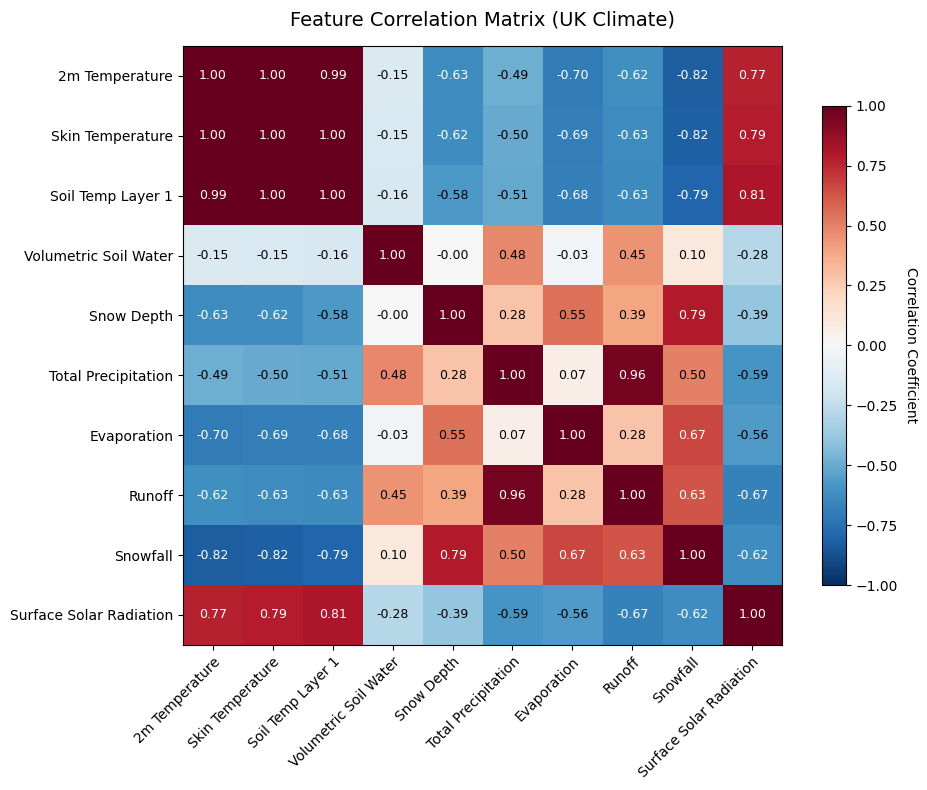

In [7]:
df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Correlation Calculation
df_corr = df[vars_10].copy()
df_corr.rename(columns=var_map, inplace=True)
corr_matrix = df_corr.corr()

# ---------------------------
# 2. Pure Matplotlib Plotting
# ---------------------------
print("Generating Plot...")
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap
# 'RdBu_r' is Red-Blue reversed (Red=Pos, Blue=Neg)
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Add Colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Correlation Coefficient", rotation=-90, va="bottom")

# Set Ticks and Labels
ax.set_xticks(np.arange(len(df_corr.columns)))
ax.set_yticks(np.arange(len(df_corr.columns)))
ax.set_xticklabels(df_corr.columns)
ax.set_yticklabels(df_corr.columns)

# Rotate labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(df_corr.columns)):
    for j in range(len(df_corr.columns)):
        val = corr_matrix.iloc[i, j]
        # Text color logic: White text if background is dark, Black if light
        text_color = "white" if abs(val) > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontsize=9)

ax.set_title("Feature Correlation Matrix (UK Climate)", fontsize=14, pad=15)
fig.tight_layout()

save_path = os.path.join(out_folder, 'feature_correlation_matrix_matplotlib.png')
plt.savefig(save_path, dpi=300)
print(f"Plot saved to: {save_path}")
plt.show()


--- 1. LOADING DATA ---
Data Loaded. Train: (167616, 10), Test: (55872, 10)

   ANALYSIS REPORT: 1. Random Forest
 > Running 5-Fold Cross-Validation...

--- PERFORMANCE METRICS ---
Accuracy (Train):      1.0000
Accuracy (Test):       0.8894
Accuracy (5-Fold CV):  0.8807 ± 0.0006

              precision    recall  f1-score   support

    Pre-1990       0.89      0.92      0.90     31040
   Post-1990       0.89      0.85      0.87     24832

    accuracy                           0.89     55872
   macro avg       0.89      0.89      0.89     55872
weighted avg       0.89      0.89      0.89     55872

 > Calculating Feature Importance...


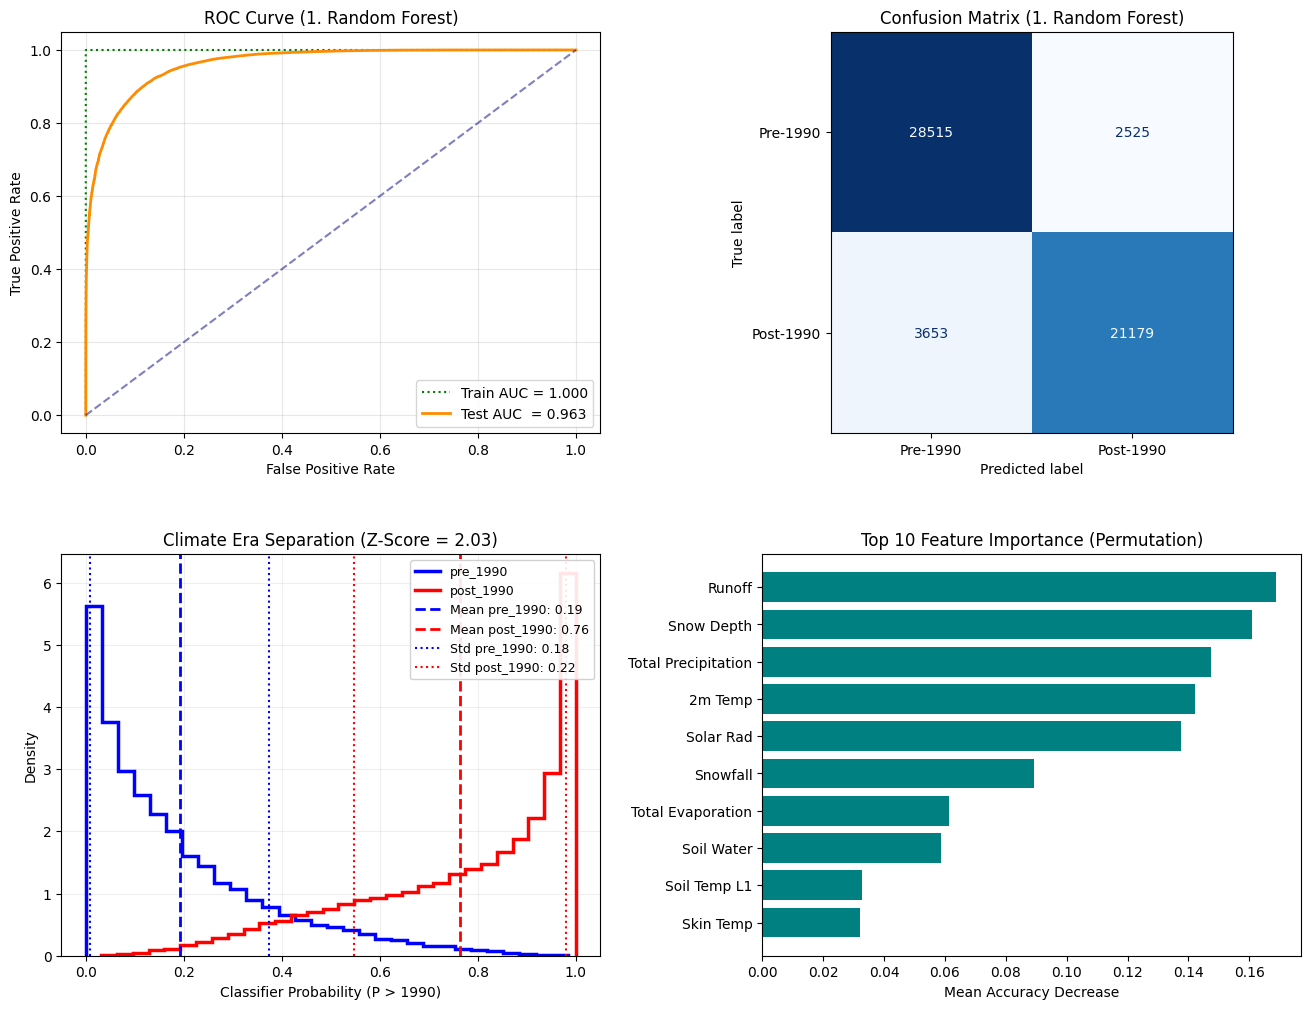


   ANALYSIS REPORT: 2. Neural Network (MLP)
 > Running 5-Fold Cross-Validation...

--- PERFORMANCE METRICS ---
Accuracy (Train):      0.8848
Accuracy (Test):       0.8757
Accuracy (5-Fold CV):  0.8687 ± 0.0082

              precision    recall  f1-score   support

    Pre-1990       0.88      0.90      0.89     31040
   Post-1990       0.87      0.85      0.86     24832

    accuracy                           0.88     55872
   macro avg       0.87      0.87      0.87     55872
weighted avg       0.88      0.88      0.88     55872

 > Calculating Feature Importance...


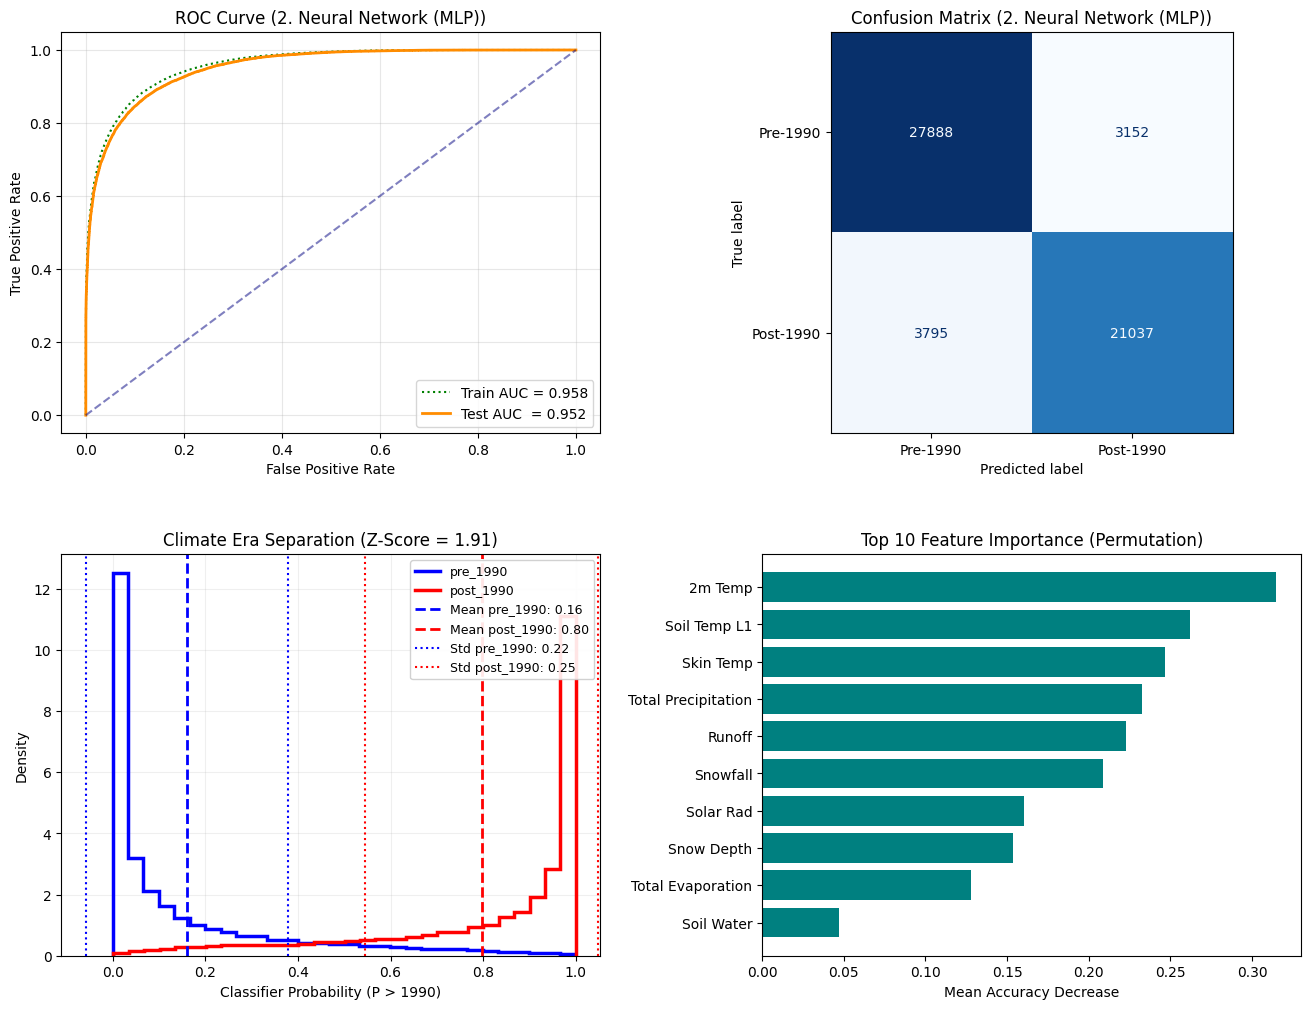


   ANALYSIS REPORT: 3. KNN
 > Running 5-Fold Cross-Validation...

--- PERFORMANCE METRICS ---
Accuracy (Train):      1.0000
Accuracy (Test):       0.8461
Accuracy (5-Fold CV):  0.8368 ± 0.0008

              precision    recall  f1-score   support

    Pre-1990       0.85      0.88      0.86     31040
   Post-1990       0.84      0.80      0.82     24832

    accuracy                           0.85     55872
   macro avg       0.85      0.84      0.84     55872
weighted avg       0.85      0.85      0.85     55872

 > Calculating Feature Importance...


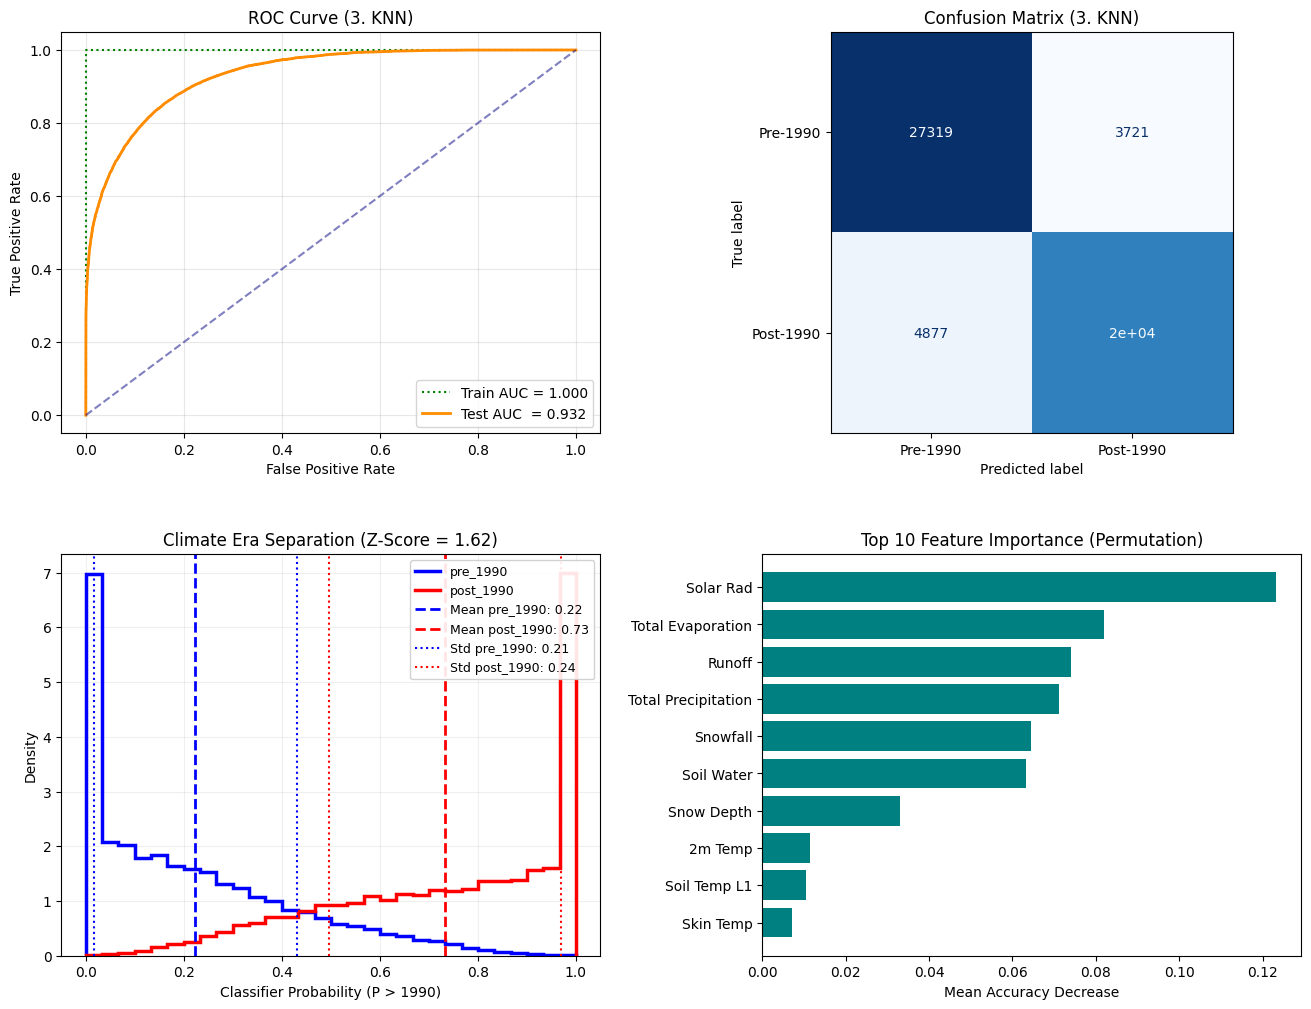



--- ALL REPORTS COMPLETE ---


In [11]:
# ==============================================================================
# FINAL RESULTS GENERATOR: The "Big Three" + EXACT VISUAL MATCH
# ==============================================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
from scipy.stats import sem, t
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay, accuracy_score)
from sklearn.inspection import permutation_importance
from matplotlib.lines import Line2D # Needed for custom legend

# ---------------------------
# 1. Setup & Data Loading
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_final_reports_v2'
os.makedirs(out_folder, exist_ok=True)

vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
var_map = {
    't2m': '2m Temp', 'skt': 'Skin Temp', 'stl1': 'Soil Temp L1',
    'swvl1': 'Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precipitation',
    'e': 'Total Evaporation', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Solar Rad'
}

print("\n--- 1. LOADING DATA ---")
ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

# UK Mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

for v in vars_10:
    da = uk_masked[v]
    if v in ['tp', 'e', 'ro', 'sf']: 
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    elif v == 'ssrd': 
        #yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
    else: 
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15 
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Split
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
X = df[feature_cols].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Data Loaded. Train: {X_train.shape}, Test: {X_test.shape}")

# ---------------------------
# 2. Define The 3 Models
# ---------------------------
rf_clf = RandomForestClassifier(
    n_estimators=321, max_depth=None, min_samples_leaf=1, 
    min_samples_split=5, max_features='sqrt', bootstrap=False, 
    n_jobs=-1, random_state=42
)

mlp_clf = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(200, 100), activation='relu', 
        alpha=0.02994250789732435, learning_rate_init=0.0016599452033620266, max_iter=500, 
        early_stopping=True, random_state=42
    )
)

knn_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=28, p=1, weights='distance', n_jobs=-1
    )
)

models = {
    "1. Random Forest": rf_clf,
    "2. Neural Network (MLP)": mlp_clf,
    "3. KNN": knn_clf
}

# ---------------------------
# 3. The Dashboard Generator (Updated Visuals)
# ---------------------------
def generate_dashboard(name, model, X_train, y_train, X_test, y_test, feat_names):
    print(f"\n{'='*80}")
    print(f"   ANALYSIS REPORT: {name}")
    print(f"{'='*80}")
    
    # --- A. Training & Metrics ---
    model.fit(X_train, y_train)
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = model.predict(X_test)
    
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    
    print(" > Running 5-Fold Cross-Validation...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_cv = cv_scores.mean()
    confidence = sem(cv_scores) * t.ppf((1 + 0.95) / 2, len(cv_scores) - 1)
    
    print(f"\n--- PERFORMANCE METRICS ---")
    print(f"Accuracy (Train):      {acc_train:.4f}")
    print(f"Accuracy (Test):       {acc_test:.4f}")
    print(f"Accuracy (5-Fold CV):  {mean_cv:.4f} ± {confidence:.4f}")
    print("\n" + classification_report(y_test, y_pred_test, target_names=['Pre-1990', 'Post-1990']))

    # --- B. Visualization Grid ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # -------------------------------------------------------
    # 1. DUAL ROC CURVE
    # -------------------------------------------------------
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    auc_train = auc(fpr_train, tpr_train)
    
    axes[0, 0].plot(fpr_train, tpr_train, linestyle=':', color='green', label=f'Train AUC = {auc_train:.3f}')
    axes[0, 0].plot(fpr_test, tpr_test, linestyle='-', color='darkorange', lw=2, label=f'Test AUC  = {auc_test:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.5)
    axes[0, 0].set_title(f'ROC Curve ({name})')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 2. CONFUSION MATRIX
    # -------------------------------------------------------
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre-1990', 'Post-1990'])
    disp.plot(cmap='Blues', ax=axes[0, 1], colorbar=False)
    axes[0, 1].set_title(f'Confusion Matrix ({name})')
    
    # -------------------------------------------------------
    # 3. HISTOGRAM (EXACT MATCH STYLE)
    # -------------------------------------------------------
    probs_pre = y_prob_test[y_test == 0]
    probs_post = y_prob_test[y_test == 1]
    
    mu_pre, mu_post = np.mean(probs_pre), np.mean(probs_post)
    std_pre, std_post = np.std(probs_pre), np.std(probs_post)
    
    if (std_pre**2 + std_post**2) > 0:
        z_score = abs(mu_post - mu_pre) / np.sqrt(std_pre**2 + std_post**2)
    else:
        z_score = 0.0
        
    # Plot Step Histograms (Bold Lines)
    axes[1, 0].hist(probs_pre, bins=30, density=True, histtype='step', 
                    color='blue', linewidth=2.5, label='_nolegend_')
    axes[1, 0].hist(probs_post, bins=30, density=True, histtype='step', 
                    color='red', linewidth=2.5, label='_nolegend_')
    
    # Add Mean Lines (Dashed)
    axes[1, 0].axvline(mu_pre, color='blue', linestyle='--', linewidth=2)
    axes[1, 0].axvline(mu_post, color='red', linestyle='--', linewidth=2)
    
    # Add Std Dev Lines (Dotted)
    axes[1, 0].axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

    # TITLES AND LABELS
    axes[1, 0].set_title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
    axes[1, 0].set_xlabel('Classifier Probability (P > 1990)')
    axes[1, 0].set_ylabel('Density') # Added Y-Label
    axes[1, 0].grid(True, alpha=0.2)

    # CUSTOM LEGEND (To match your image exactly)
    custom_lines = [
        Line2D([0], [0], color='blue', lw=2.5), # Solid Blue Box
        Line2D([0], [0], color='red', lw=2.5),  # Solid Red Box
        Line2D([0], [0], color='blue', linestyle='--', lw=2), # Blue Dashed
        Line2D([0], [0], color='red', linestyle='--', lw=2),  # Red Dashed
        Line2D([0], [0], color='blue', linestyle=':', lw=1.5),# Blue Dotted
        Line2D([0], [0], color='red', linestyle=':', lw=1.5)  # Red Dotted
    ]
    custom_labels = [
        'pre_1990',
        'post_1990',
        f'Mean pre_1990: {mu_pre:.2f}',
        f'Mean post_1990: {mu_post:.2f}',
        f'Std pre_1990: {std_pre:.2f}',
        f'Std post_1990: {std_post:.2f}'
    ]
    # Place Legend (Top Right, slightly smaller text)
    axes[1, 0].legend(custom_lines, custom_labels, loc='upper right', fontsize='9', framealpha=0.9)
    
    # -------------------------------------------------------
    # 4. FEATURE IMPORTANCE
    # -------------------------------------------------------
    print(" > Calculating Feature Importance...")
    perm_result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    sorted_idx = perm_result.importances_mean.argsort()[::-1]
    
    clean_names = [var_map.get(feat_names[i], feat_names[i]) for i in sorted_idx]
    
    top_n = 10
    axes[1, 1].barh(range(top_n), perm_result.importances_mean[sorted_idx][:top_n], color='teal')
    axes[1, 1].set_yticks(range(top_n))
    axes[1, 1].set_yticklabels(clean_names[:top_n])
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('Top 10 Feature Importance (Permutation)')
    axes[1, 1].set_xlabel('Mean Accuracy Decrease')
    
    plt.show()

# ---------------------------
# 4. Run Everything
# ---------------------------
for model_name, model_obj in models.items():
    generate_dashboard(model_name, model_obj, X_train, y_train, X_test, y_test, feature_cols)

print(f"\n\n--- ALL REPORTS COMPLETE ---")




--- 1. LOADING DATA ---
Data Loaded. Train: (167616, 10), Test: (55872, 10)

   ELITE ENSEMBLE REPORT (RF + MLP)
 > Running 5-Fold Cross-Validation...

--- PERFORMANCE METRICS ---
Accuracy (Train):      0.9905
Accuracy (Test):       0.8953
Accuracy (5-Fold CV):  0.8906 ± 0.0046

              precision    recall  f1-score   support

    Pre-1990       0.89      0.92      0.91     31040
   Post-1990       0.90      0.86      0.88     24832

    accuracy                           0.90     55872
   macro avg       0.90      0.89      0.89     55872
weighted avg       0.90      0.90      0.90     55872

 > Calculating Permutation Importance (Ensemble)...


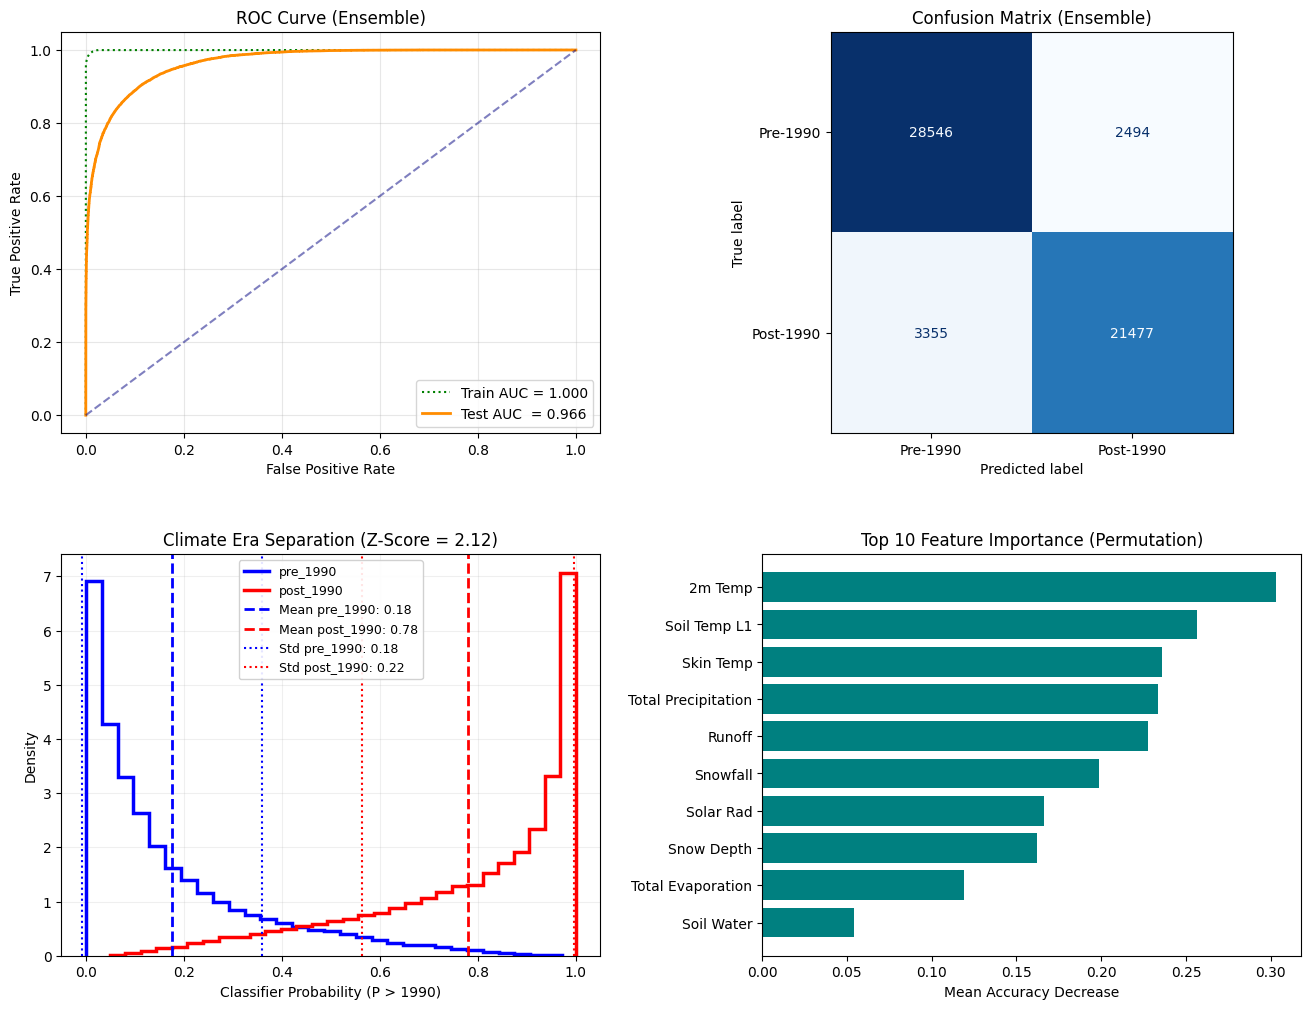

In [12]:
# ==============================================================================
# FINAL RESULTS: ELITE ENSEMBLE (RF + MLP)
# ==============================================================================
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
from scipy.stats import sem, t
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from matplotlib.lines import Line2D # For the custom legend

# ---------------------------
# 1. Setup & Data Loading
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_final_reports_v2'
os.makedirs(out_folder, exist_ok=True)

vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
var_map = {
    't2m': '2m Temp', 'skt': 'Skin Temp', 'stl1': 'Soil Temp L1',
    'swvl1': 'Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precipitation',
    'e': 'Total Evaporation', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Solar Rad'
}

print("\n--- 1. LOADING DATA ---")
ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

# UK Mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

for v in vars_10:
    da = uk_masked[v]
    if v in ['tp', 'e', 'ro', 'sf']: 
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    elif v == 'ssrd': 
        #yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
    else: 
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15 
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Split
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
X = df[feature_cols].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Data Loaded. Train: {X_train.shape}, Test: {X_test.shape}")

# ---------------------------
# 2. Define Optimized Models
# ---------------------------

# A. Optimized Random Forest
rf = RandomForestClassifier(n_estimators=321, max_depth=None, min_samples_leaf=1, min_samples_split=5, max_features='sqrt', bootstrap=False, n_jobs=-1, random_state=42)

# B. Optimized MLP (Neural Network)
mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', alpha=0.02994250789732435, learning_rate_init=0.0016599452033620266, max_iter=500, early_stopping=True, random_state=42))


# ---------------------------
# 3. Create The Elite Ensemble
# ---------------------------
elite_ensemble = VotingClassifier(
    estimators=[('RF', rf), ('MLP', mlp)],
    voting='soft',
    weights=[1, 1], 
    n_jobs=-1
)

# ---------------------------
# 4. The Dashboard Generator (Exact Match Style)
# ---------------------------
def generate_ensemble_dashboard(model, X_train, y_train, X_test, y_test, feat_names):
    print(f"\n{'='*80}")
    print(f"   ELITE ENSEMBLE REPORT (RF + MLP)")
    print(f"{'='*80}")
    
    # --- A. Training ---
    model.fit(X_train, y_train)
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = model.predict(X_test)
    
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    
    print(" > Running 5-Fold Cross-Validation...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mean_cv = cv_scores.mean()
    confidence = sem(cv_scores) * t.ppf((1 + 0.95) / 2, len(cv_scores) - 1)
    
    print(f"\n--- PERFORMANCE METRICS ---")
    print(f"Accuracy (Train):      {acc_train:.4f}")
    print(f"Accuracy (Test):       {acc_test:.4f}")
    print(f"Accuracy (5-Fold CV):  {mean_cv:.4f} ± {confidence:.4f}")
    print("\n" + classification_report(y_test, y_pred_test, target_names=['Pre-1990', 'Post-1990']))

    # --- B. Visualization Grid ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # -------------------------------------------------------
    # 1. DUAL ROC CURVE
    # -------------------------------------------------------
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    auc_train = auc(fpr_train, tpr_train)
    
    axes[0, 0].plot(fpr_train, tpr_train, linestyle=':', color='green', label=f'Train AUC = {auc_train:.3f}')
    axes[0, 0].plot(fpr_test, tpr_test, linestyle='-', color='darkorange', lw=2, label=f'Test AUC  = {auc_test:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('ROC Curve (Ensemble)')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # 2. CONFUSION MATRIX
    # -------------------------------------------------------
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre-1990', 'Post-1990'])
    disp.plot(cmap='Blues', ax=axes[0, 1], colorbar=False)
    axes[0, 1].set_title('Confusion Matrix (Ensemble)')
    
    # -------------------------------------------------------
    # 3. HISTOGRAM (EXACT MATCH STYLE)
    # -------------------------------------------------------
    probs_pre = y_prob_test[y_test == 0]
    probs_post = y_prob_test[y_test == 1]
    
    mu_pre, mu_post = np.mean(probs_pre), np.mean(probs_post)
    std_pre, std_post = np.std(probs_pre), np.std(probs_post)
    
    if (std_pre**2 + std_post**2) > 0:
        z_score = abs(mu_post - mu_pre) / np.sqrt(std_pre**2 + std_post**2)
    else:
        z_score = 0.0
        
    # Plot Step Histograms (Bold Lines)
    axes[1, 0].hist(probs_pre, bins=30, density=True, histtype='step', 
                    color='blue', linewidth=2.5, label='_nolegend_')
    axes[1, 0].hist(probs_post, bins=30, density=True, histtype='step', 
                    color='red', linewidth=2.5, label='_nolegend_')
    
    # Add Mean Lines (Dashed)
    axes[1, 0].axvline(mu_pre, color='blue', linestyle='--', linewidth=2)
    axes[1, 0].axvline(mu_post, color='red', linestyle='--', linewidth=2)
    
    # Add Std Dev Lines (Dotted)
    axes[1, 0].axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

    # TITLES AND LABELS
    axes[1, 0].set_title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
    axes[1, 0].set_xlabel('Classifier Probability (P > 1990)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].grid(True, alpha=0.2)

    # CUSTOM LEGEND (Exact Match)
    custom_lines = [
        Line2D([0], [0], color='blue', lw=2.5),
        Line2D([0], [0], color='red', lw=2.5),
        Line2D([0], [0], color='blue', linestyle='--', lw=2),
        Line2D([0], [0], color='red', linestyle='--', lw=2),
        Line2D([0], [0], color='blue', linestyle=':', lw=1.5),
        Line2D([0], [0], color='red', linestyle=':', lw=1.5)
    ]
    custom_labels = [
        'pre_1990',
        'post_1990',
        f'Mean pre_1990: {mu_pre:.2f}',
        f'Mean post_1990: {mu_post:.2f}',
        f'Std pre_1990: {std_pre:.2f}',
        f'Std post_1990: {std_post:.2f}'
    ]
    axes[1, 0].legend(custom_lines, custom_labels, loc='upper center', fontsize='9', framealpha=0.9)
    
    # -------------------------------------------------------
    # 4. FEATURE IMPORTANCE (Permutation)
    # -------------------------------------------------------
    print(" > Calculating Permutation Importance (Ensemble)...")
    perm_result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    sorted_idx = perm_result.importances_mean.argsort()[::-1]
    
    clean_names = [var_map.get(feat_names[i], feat_names[i]) for i in sorted_idx]
    
    top_n = 10
    axes[1, 1].barh(range(top_n), perm_result.importances_mean[sorted_idx][:top_n], color='teal')
    axes[1, 1].set_yticks(range(top_n))
    axes[1, 1].set_yticklabels(clean_names[:top_n])
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('Top 10 Feature Importance (Permutation)')
    axes[1, 1].set_xlabel('Mean Accuracy Decrease')
    
    plt.show()

# 5. Run It
# ---------
generate_ensemble_dashboard(elite_ensemble, X_train, y_train, X_test, y_test, feature_cols)


   STARTING FINAL ANALYSIS (WITH 3-FOLD CV)
 > Loading Data and Masking UK...
 > Applying Physics Corrections (Days Multiplier)...
 > Reshaping and Shifting Winter...

   DATAFRAME DIMENSIONS CHECK
Total Shape:    (223488, 44)
Total Samples:  223488 (Rows)
Total Columns:  44
Feature Count:  40 (Should be 40)
First 5 Feats:  ['e_Autumn', 'e_Spring', 'e_Summer', 'e_Winter', 'ro_Autumn']

 > Data Ready. Training on 167616 samples, Testing on 55872.
 > Training Ensemble (Full Train)...
 > Running 3-Fold Cross-Validation (checking robustness)...

       PERFORMANCE METRICS
Accuracy (Train):      1.0000
Accuracy (Test):       0.9997
Accuracy (3-Fold CV):  0.9995 ± 0.0001
----------------------------------------
              precision    recall  f1-score   support

    Pre-1990       1.00      1.00      1.00     31040
   Post-1990       1.00      1.00      1.00     24832

    accuracy                           1.00     55872
   macro avg       1.00      1.00      1.00     55872
weighted avg 

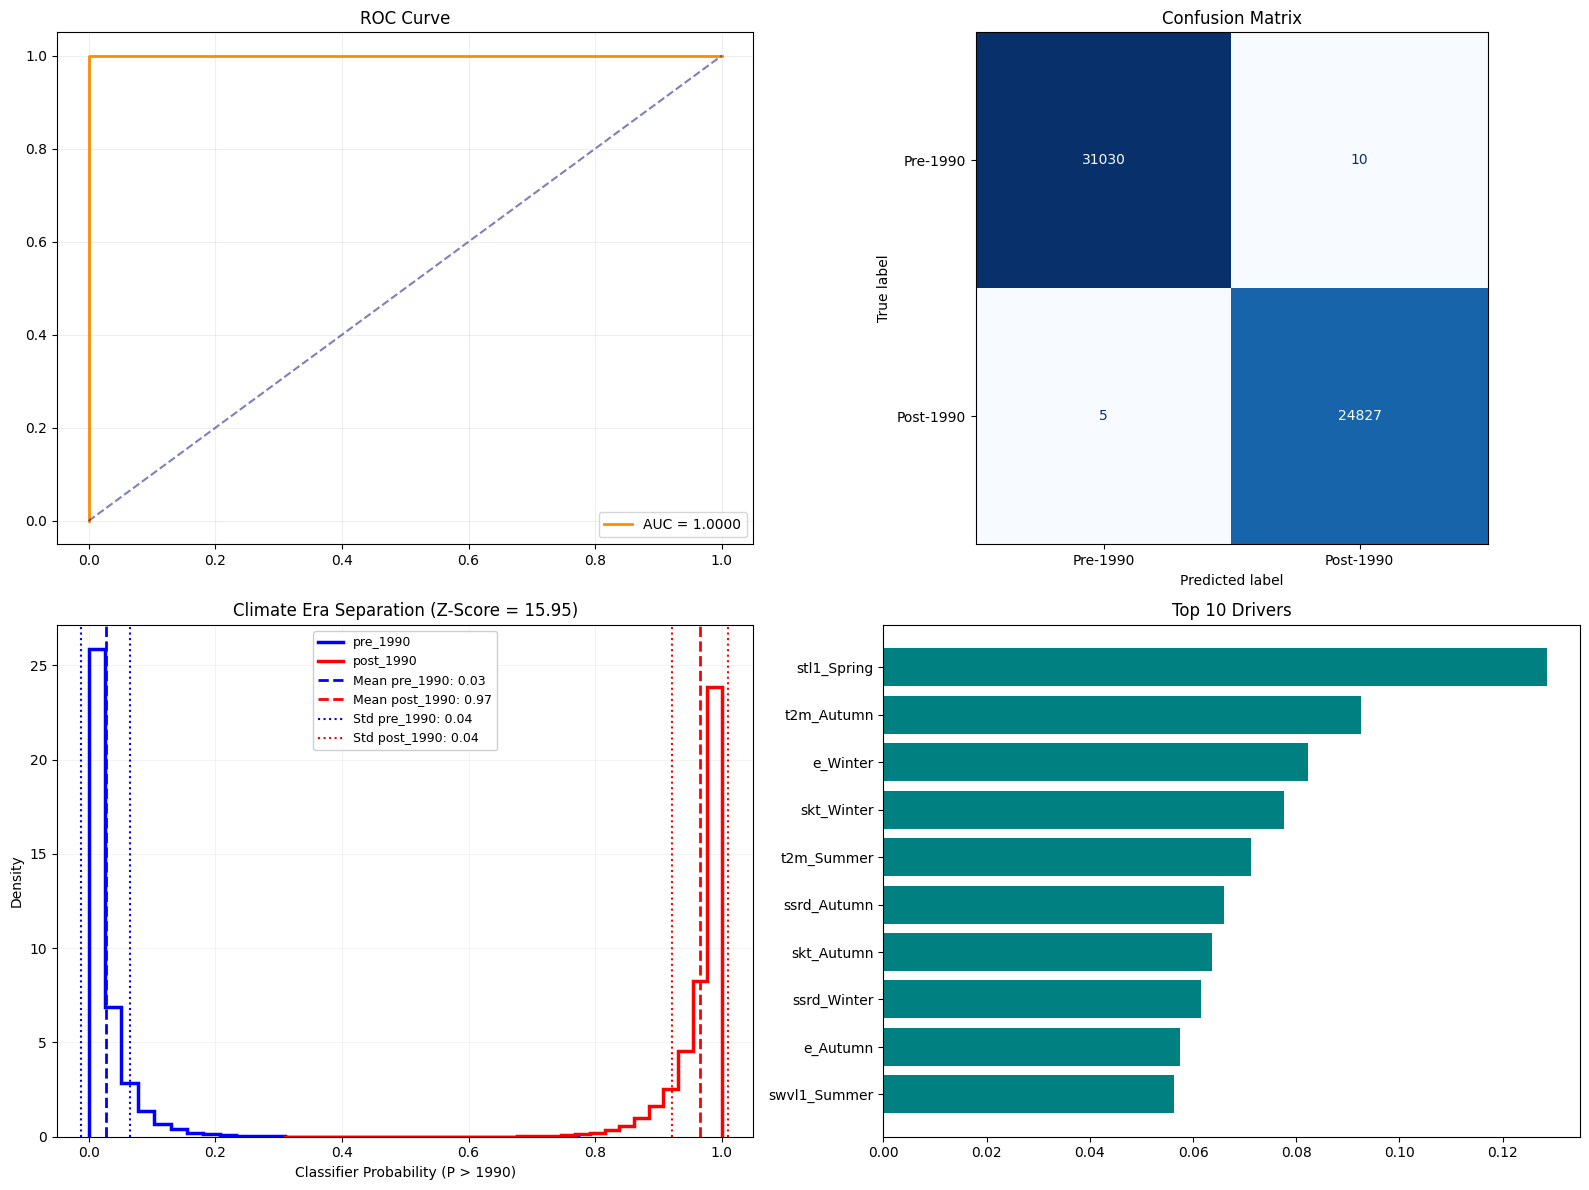

 > DONE.


In [13]:
# ==============================================================================
# FINAL THESIS SCRIPT: SEASONAL ENSEMBLE + PHYSICS + 3-FOLD CV + EXACT DASHBOARD
# ==============================================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from matplotlib.lines import Line2D

# ---------------------------
# 1. Configuration & Setup
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'

vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
accum_vars = ['tp', 'e', 'ro', 'sf', 'ssrd'] # Variables that need summing (Fluxes + Energy)

print(f"{'='*80}")
print(f"   STARTING FINAL ANALYSIS (WITH 3-FOLD CV)")
print(f"{'='*80}")

# ---------------------------
# 2. Data Loading & Physics Corrections
# ---------------------------
print(" > Loading Data and Masking UK...")
ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

# Mask for United Kingdom
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics Loop
print(" > Applying Physics Corrections (Days Multiplier)...")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])

processed_das = []

for v in vars_10:
    da = uk_masked[v]
    
    if v in accum_vars:
        # Accumulations: Multiply by days to get Monthly Total
        monthly_total = da * days_3d
        # Resample to Season (Sum of the 3 months)
        season_da = monthly_total.resample({time_coord: 'QS-DEC'}).sum()
        
        # Unit Conversion: Meters -> Millimeters (Water only)
        if v in ['tp', 'e', 'ro', 'sf']:
            season_da = season_da * 1000.0
        # ssrd (Solar) is left in Joules (already accumulated)
            
    else:
        # Instantaneous: Average of the 3 months
        season_da = da.resample({time_coord: 'QS-DEC'}).mean()
        
        # Unit Conversion: Kelvin -> Celsius
        if v in ['t2m', 'skt', 'stl1']:
            season_da = season_da - 273.15
            
    season_da.name = v
    processed_das.append(season_da)

ds_seasonal = xr.merge(processed_das)

# ---------------------------
# 3. Reshaping & Winter Shift
# ---------------------------
print(" > Reshaping and Shifting Winter...")
df_long = ds_seasonal.to_dataframe().reset_index().dropna(how='any')
df_long['season_month'] = df_long[time_coord].dt.month
df_long['year'] = df_long[time_coord].dt.year

# THE SHIFT: Dec 1989 becomes Winter 1990
df_long.loc[df_long['season_month'] == 12, 'year'] += 1

season_map = {12:'Winter', 1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring',
              6:'Summer', 7:'Summer', 8:'Summer', 9:'Autumn', 10:'Autumn', 11:'Autumn'}
df_long['season'] = df_long['season_month'].map(season_map)
df_long = df_long[df_long['year'] < 2022] 

# Pivot to 40 Columns (Wide Format)
df_pivot = df_long.pivot_table(index=['year', 'lat', 'lon'], columns='season', values=vars_10)
df_pivot.columns = [f"{var}_{season}" for var, season in df_pivot.columns]
df_pivot = df_pivot.reset_index()

# Target Label
df_pivot['target'] = (df_pivot['year'] >= 1990).astype(int)

# ---------------------------
# 4. Dimension Double-Check
# ---------------------------
print(f"\n{'='*40}")
print(f"   DATAFRAME DIMENSIONS CHECK")
print(f"{'='*40}")
print(f"Total Shape:    {df_pivot.shape}")
print(f"Total Samples:  {df_pivot.shape[0]} (Rows)")
print(f"Total Columns:  {df_pivot.shape[1]}")

feature_cols = [c for c in df_pivot.columns if c not in ['year', 'target', 'lat', 'lon']]
print(f"Feature Count:  {len(feature_cols)} (Should be 40)")
print(f"First 5 Feats:  {feature_cols[:5]}")
print(f"{'='*40}\n")

# Split
X = df_pivot[feature_cols].values
y = df_pivot['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f" > Data Ready. Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]}.")

# ---------------------------
# 5. Model Definition (Optimized)
# ---------------------------
rf_opt = RandomForestClassifier(
    n_estimators=321, max_depth=None, min_samples_leaf=1, 
    min_samples_split=5, max_features='sqrt', bootstrap=False, 
    n_jobs=-1, random_state=42
)

mlp_opt = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(200, 100), activation='relu', 
        alpha=0.02994250789732435, learning_rate_init=0.0016599452033620266, 
        max_iter=500, early_stopping=True, random_state=42
    )
)

seasonal_ensemble = VotingClassifier(
    estimators=[('RF', rf_opt), ('MLP', mlp_opt)],
    voting='soft', weights=[1, 1], n_jobs=-1
)

# ---------------------------
# 6. Dashboard Generation
# ---------------------------
print(" > Training Ensemble (Full Train)...")
seasonal_ensemble.fit(X_train, y_train)

# --- NEW: 3-Fold Cross-Validation ---
print(" > Running 3-Fold Cross-Validation (checking robustness)...")
cv_scores = cross_val_score(seasonal_ensemble, X_train, y_train, cv=3, n_jobs=-1)

# Predictions
y_pred_test = seasonal_ensemble.predict(X_test)
y_prob_test = seasonal_ensemble.predict_proba(X_test)[:, 1]

# Metrics
acc_train = seasonal_ensemble.score(X_train, y_train)
acc_test = seasonal_ensemble.score(X_test, y_test)

print("\n" + "="*40)
print("       PERFORMANCE METRICS")
print("="*40)
print(f"Accuracy (Train):      {acc_train:.4f}")
print(f"Accuracy (Test):       {acc_test:.4f}")
print(f"Accuracy (3-Fold CV):  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("-" * 40)
print(classification_report(y_test, y_pred_test, target_names=['Pre-1990', 'Post-1990']))

# --- PLOTTING ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot 1: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc(fpr, tpr):.4f}')
axes[0, 0].plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.5)
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.2)

# Plot 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre-1990', 'Post-1990']).plot(cmap='Blues', ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title('Confusion Matrix')

# Plot 3: HISTOGRAM (EXACT MATCH)
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]
mu_pre, mu_post = np.mean(probs_pre), np.mean(probs_post)
std_pre, std_post = np.std(probs_pre), np.std(probs_post)

if (std_pre**2 + std_post**2) > 0:
    z_score = abs(mu_post - mu_pre) / np.sqrt(std_pre**2 + std_post**2)
else:
    z_score = 0.0

# Bold Step Histograms
axes[1, 0].hist(probs_pre, bins=30, density=True, histtype='step', color='blue', linewidth=2.5, label='_nolegend_')
axes[1, 0].hist(probs_post, bins=30, density=True, histtype='step', color='red', linewidth=2.5, label='_nolegend_')

# Lines (Mean = Dashed, Std = Dotted)
axes[1, 0].axvline(mu_pre, color='blue', linestyle='--', linewidth=2)
axes[1, 0].axvline(mu_post, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5)
axes[1, 0].axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)
axes[1, 0].axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5)
axes[1, 0].axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

axes[1, 0].set_title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
axes[1, 0].set_xlabel('Classifier Probability (P > 1990)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

# Detailed Legend
custom_lines = [
    Line2D([0], [0], color='blue', lw=2.5), Line2D([0], [0], color='red', lw=2.5),
    Line2D([0], [0], color='blue', linestyle='--', lw=2), Line2D([0], [0], color='red', linestyle='--', lw=2),
    Line2D([0], [0], color='blue', linestyle=':', lw=1.5), Line2D([0], [0], color='red', linestyle=':', lw=1.5)
]
custom_labels = [
    'pre_1990', 'post_1990',
    f'Mean pre_1990: {mu_pre:.2f}', f'Mean post_1990: {mu_post:.2f}',
    f'Std pre_1990: {std_pre:.2f}', f'Std post_1990: {std_post:.2f}'
]
axes[1, 0].legend(custom_lines, custom_labels, loc='upper center', fontsize='9', framealpha=0.95)

# Plot 4: Feature Importance
print(" > Calculating Feature Importance...")
perm_result = permutation_importance(seasonal_ensemble, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = perm_result.importances_mean.argsort()[::-1]

axes[1, 1].barh(range(10), perm_result.importances_mean[sorted_idx][:10], color='teal')
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels([feature_cols[i] for i in sorted_idx[:10]])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Top 10 Drivers')

plt.tight_layout()
plt.show()
print(" > DONE.")


--- 1. LOADING & PROCESSING DATA ---
 > Calculating Physical Totals & Averages...
 > Cleaning Data & Adding One-Hot Seasons...
   -> Dropping 'expver' (Safety)
   -> Dropping 'number' (Safety)
 > Final Features: ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd', 'is_Winter', 'is_Spring', 'is_Summer', 'is_Autumn']
 > Total Rows: 2681856
 > Splitting Data...

   ELITE ENSEMBLE REPORT (MONTHLY + EXACT HISTOGRAM)
 > Training Ensemble (please wait)...

--- RESULTS ---
Accuracy (Train): 0.7882
Accuracy (Test):  0.7814

              precision    recall  f1-score   support

    Pre-1990       0.77      0.87      0.82    372480
   Post-1990       0.80      0.67      0.73    297984

    accuracy                           0.78    670464
   macro avg       0.79      0.77      0.77    670464
weighted avg       0.78      0.78      0.78    670464

 > Calculating Importance (Subsample)...


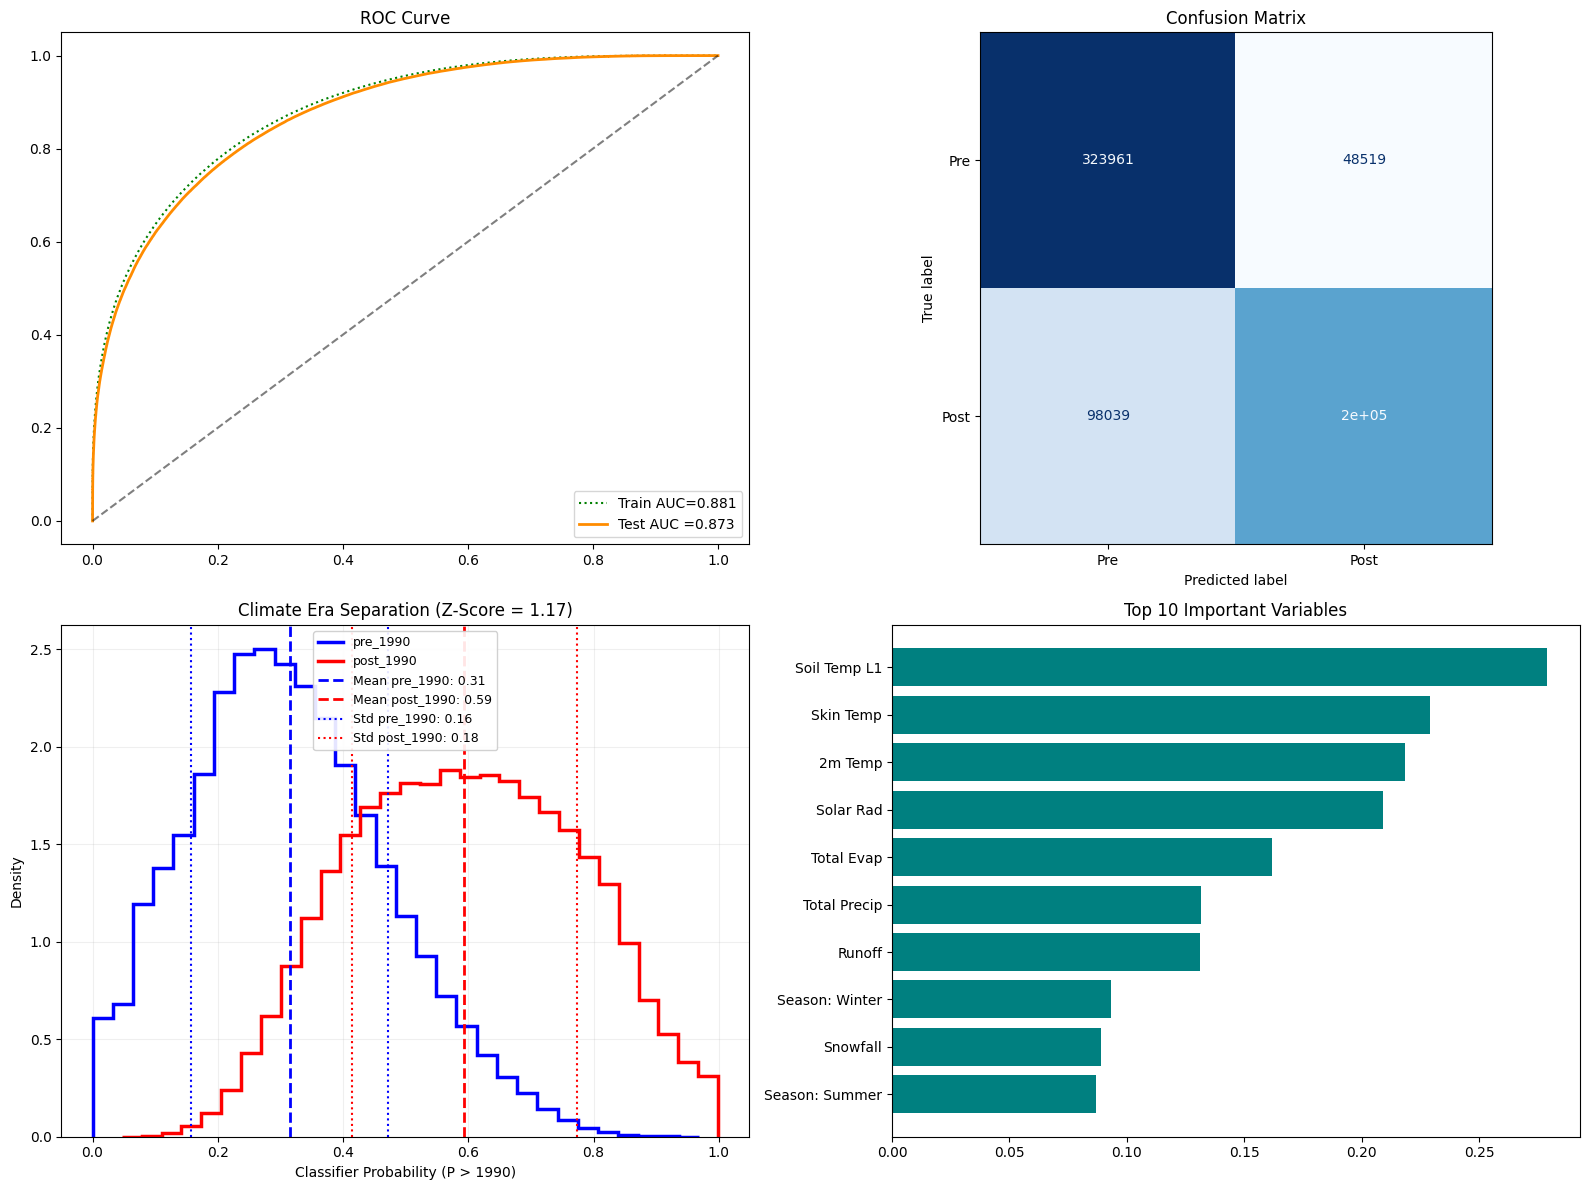

In [2]:
# ==============================================================================
# FINAL RESULTS: ELITE ENSEMBLE (MONTHLY)
# ==============================================================================
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from matplotlib.lines import Line2D

# ---------------------------
# 1. SETUP & DATA LOADING
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_final_reports_monthly_exact'
os.makedirs(out_folder, exist_ok=True)

# Define Variables
vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
accum_vars = ['tp', 'e', 'ro', 'sf', 'ssrd']

var_map = {
    't2m': '2m Temp', 'skt': 'Skin Temp', 'stl1': 'Soil Temp L1',
    'swvl1': 'Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precip',
    'e': 'Total Evap', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Solar Rad',
    'is_Winter': 'Season: Winter', 'is_Summer': 'Season: Summer',
    'is_Spring': 'Season: Spring', 'is_Autumn': 'Season: Autumn'
}

print("\n--- 1. LOADING & PROCESSING DATA ---")
ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics Helper
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])

monthly_das = []
print(" > Calculating Physical Totals & Averages...")

for v in vars_10:
    da = uk_masked[v]
    if v in accum_vars: 
        if v == 'ssrd':
             monthly_da = da * days_3d
        else:
             monthly_da = da * days_3d * 1000.0
    else: 
        monthly_da = da
        if v in ['t2m', 'skt', 'stl1']: 
            monthly_da = da - 273.15 
            
    monthly_da.name = v
    monthly_das.append(monthly_da)

df = xr.merge(monthly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df['year'] = df[time_coord].dt.year
df['month'] = df[time_coord].dt.month
df = df[df['year'] < 2022] 
df['target'] = (df['year'] >= 1990).astype(int)

# ---------------------------
# 2. CLEANING & SEASONALITY
# ---------------------------
print(" > Cleaning Data & Adding One-Hot Seasons...")

# SAFETY DROP (Anti-Cheat)
drop_cols = ['expver', 'number']
for c in drop_cols:
    if c in df.columns:
        print(f"   -> Dropping '{c}' (Safety)")
        df = df.drop(columns=[c])

# ONE-HOT ENCODING
df['is_Winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_Spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_Summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_Autumn'] = df['month'].isin([9, 10, 11]).astype(int)

feature_cols = [c for c in df.columns if c not in ['year', 'month', 'target', 'lat', 'lon', time_coord]]
print(f" > Final Features: {feature_cols}")

# ---------------------------
# 3. SPLITTING
# ---------------------------
X = df[feature_cols].values
y = df['target'].values

print(f" > Total Rows: {len(df)}")
print(" > Splitting Data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y 
)

# ---------------------------
# 4. TRAIN MODEL
# ---------------------------
rf = RandomForestClassifier(n_estimators=150, max_depth=15, n_jobs=-1, random_state=42)
mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, early_stopping=True, random_state=42))

elite_ensemble = VotingClassifier(estimators=[('RF', rf), ('MLP', mlp)], voting='soft', weights=[1, 1], n_jobs=-1)

# ---------------------------
# 5. DASHBOARD (UPDATED FOR EXACT HISTOGRAM MATCH)
# ---------------------------
def generate_dashboard():
    print(f"\n{'='*80}")
    print(f"   ELITE ENSEMBLE REPORT (MONTHLY + EXACT HISTOGRAM)")
    print(f"{'='*80}")
    
    print(" > Training Ensemble (please wait)...")
    elite_ensemble.fit(X_train, y_train)
    
    y_prob_test = elite_ensemble.predict_proba(X_test)[:, 1]
    y_pred_test = elite_ensemble.predict(X_test)
    y_prob_train = elite_ensemble.predict_proba(X_train)[:, 1]
    
    acc_train = elite_ensemble.score(X_train, y_train)
    acc_test = elite_ensemble.score(X_test, y_test)
    
    print(f"\n--- RESULTS ---")
    print(f"Accuracy (Train): {acc_train:.4f}")
    print(f"Accuracy (Test):  {acc_test:.4f}")
    print("\n" + classification_report(y_test, y_pred_test, target_names=['Pre-1990', 'Post-1990']))

    # PLOTS
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 1. ROC
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    auc_test = auc(fpr_test, tpr_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    auc_train = auc(fpr_train, tpr_train)
    
    axes[0, 0].plot(fpr_train, tpr_train, ':', color='green', label=f'Train AUC={auc_train:.3f}')
    axes[0, 0].plot(fpr_test, tpr_test, '-', color='darkorange', lw=2, label=f'Test AUC ={auc_test:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend(loc="lower right")
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre', 'Post'])
    disp.plot(cmap='Blues', ax=axes[0, 1], colorbar=False)
    axes[0, 1].set_title('Confusion Matrix')
    
    # -------------------------------------------------------
    # 3. EXACT MATCH HISTOGRAM
    # -------------------------------------------------------
    probs_pre = y_prob_test[y_test == 0]
    probs_post = y_prob_test[y_test == 1]
    
    mu_pre, mu_post = np.mean(probs_pre), np.mean(probs_post)
    std_pre, std_post = np.std(probs_pre), np.std(probs_post)
    
    if (std_pre**2 + std_post**2) > 0:
        z_score = abs(mu_post - mu_pre) / np.sqrt(std_pre**2 + std_post**2)
    else:
        z_score = 0.0
        
    # Plot Step Histograms (Bold Lines)
    axes[1, 0].hist(probs_pre, bins=30, density=True, histtype='step', 
                    color='blue', linewidth=2.5, label='_nolegend_')
    axes[1, 0].hist(probs_post, bins=30, density=True, histtype='step', 
                    color='red', linewidth=2.5, label='_nolegend_')
    
    # Add Mean Lines (Dashed)
    axes[1, 0].axvline(mu_pre, color='blue', linestyle='--', linewidth=2)
    axes[1, 0].axvline(mu_post, color='red', linestyle='--', linewidth=2)
    
    # Add Std Dev Lines (Dotted)
    axes[1, 0].axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5)
    axes[1, 0].axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

    # TITLES AND LABELS
    axes[1, 0].set_title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
    axes[1, 0].set_xlabel('Classifier Probability (P > 1990)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].grid(True, alpha=0.2)

    # CUSTOM LEGEND (Exact Match)
    custom_lines = [
        Line2D([0], [0], color='blue', lw=2.5),
        Line2D([0], [0], color='red', lw=2.5),
        Line2D([0], [0], color='blue', linestyle='--', lw=2),
        Line2D([0], [0], color='red', linestyle='--', lw=2),
        Line2D([0], [0], color='blue', linestyle=':', lw=1.5),
        Line2D([0], [0], color='red', linestyle=':', lw=1.5)
    ]
    custom_labels = [
        'pre_1990',
        'post_1990',
        f'Mean pre_1990: {mu_pre:.2f}',
        f'Mean post_1990: {mu_post:.2f}',
        f'Std pre_1990: {std_pre:.2f}',
        f'Std post_1990: {std_post:.2f}'
    ]
    axes[1, 0].legend(custom_lines, custom_labels, loc='upper center', fontsize='9', framealpha=0.9)
    
    # 4. Feature Importance (Subsample)
    print(" > Calculating Importance (Subsample)...")
    idx_sub = np.random.choice(len(X_test), 5000, replace=False)
    perm = permutation_importance(elite_ensemble, X_test[idx_sub], y_test[idx_sub], n_repeats=3, random_state=42, n_jobs=-1)
    
    sorted_idx = perm.importances_mean.argsort()[::-1]
    clean_names = [var_map.get(feature_cols[i], feature_cols[i]) for i in sorted_idx]
    
    axes[1, 1].barh(range(10), perm.importances_mean[sorted_idx][:10], color='teal')
    axes[1, 1].set_yticks(range(10))
    axes[1, 1].set_yticklabels(clean_names[:10])
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('Top 10 Important Variables')
    
    plt.tight_layout()
    plt.show()

generate_dashboard()

 > Calculating Annual Means...


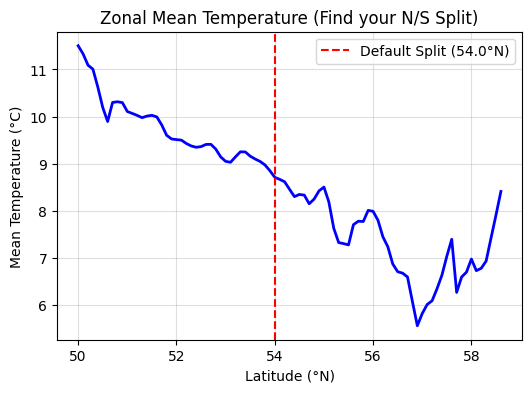


--- Entire UK: Annual 2m Temperature ---
Trend (Slope)     = 0.202 ± 0.027 °C/decade
Avg Temp          = 8.64 °C
Avg Spatial Std   = 1.42 °C

--- North UK (Lat >= 54.0°): Annual 2m Temp ---
Trend (Slope)     = 0.176 ± 0.026 °C/decade
Avg Temp          = 7.45 °C
Avg Spatial Std   = 1.17 °C

--- South UK (Lat < 54.0°): Annual 2m Temp ---
Trend (Slope)     = 0.223 ± 0.028 °C/decade
Avg Temp          = 9.58 °C
Avg Spatial Std   = 0.71 °C


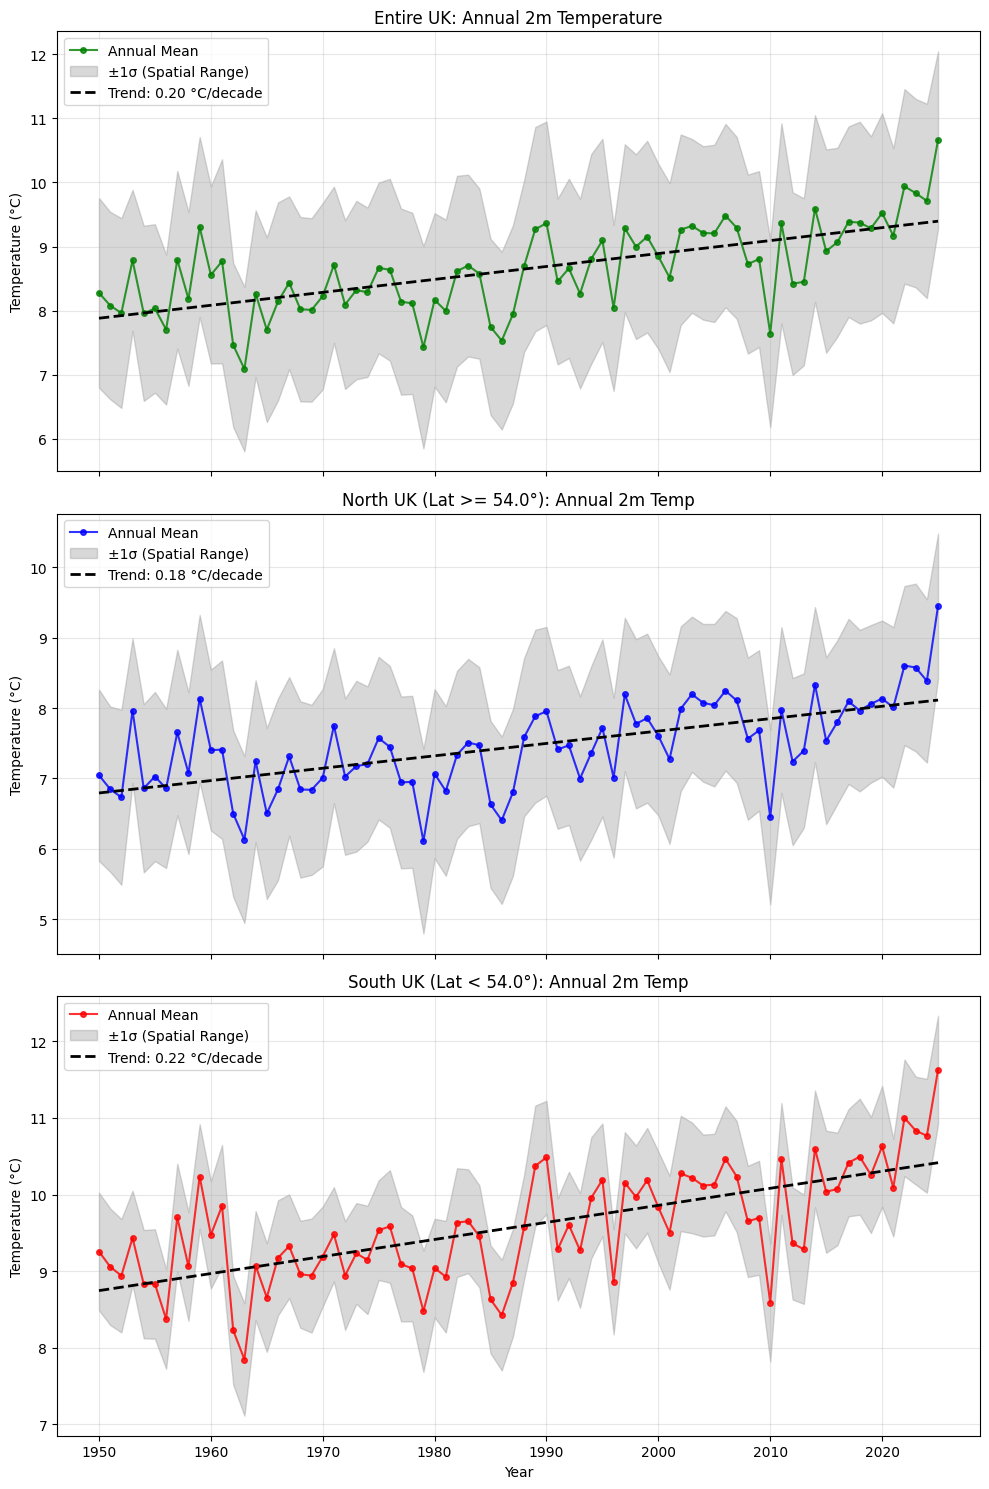

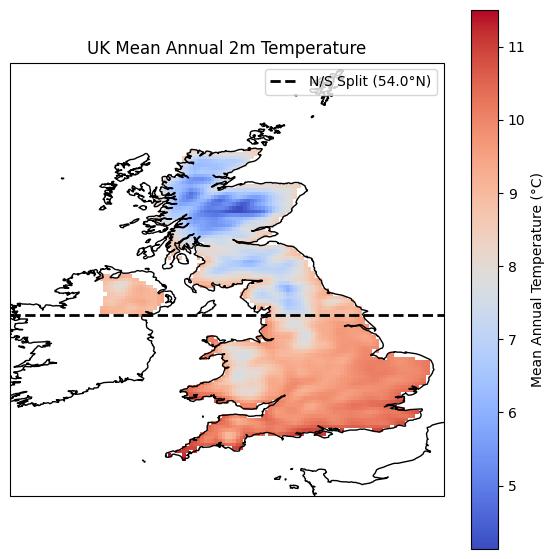

In [1]:
# ==============================================================================
# UK 2m TEMPERATURE: ANNUAL TRENDS, SPATIAL STD DEV, & NORTH/SOUTH SPLIT
# ==============================================================================
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# -------------------------
# 1. Load Data
# -------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
ds = xr.open_dataset(file_path)
varname = 't2m'  # 2m temperature

if 'longitude' in ds.coords:
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

# -------------------------
# 2. Physics: Compute Yearly Means (State Variable)
# -------------------------
print(" > Calculating Annual Means...")
# Temperature is a state, so we take the MEAn, and subtract 273.15 for Celsius
yearly_data = ds[varname].groupby('valid_time.year').mean(dim='valid_time') - 273.15

# -------------------------
# 3. Mask UK Grid Cells
# -------------------------
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
uk_mask = countries.mask(yearly_data['lon'], yearly_data['lat']) == uk_index
uk_data = yearly_data.where(uk_mask)

# -------------------------
# 4. Find the "Stark Divide" (Zonal Mean)
# -------------------------
# This plots Temperature vs Latitude so you can choose the perfect split line
zonal_mean = uk_data.mean(dim=['year', 'lon'], skipna=True)

plt.figure(figsize=(6, 4))
plt.plot(zonal_mean['lat'], zonal_mean, 'b-', lw=2)
plt.xlabel('Latitude (°N)')
plt.ylabel('Mean Temperature (°C)')
plt.title('Zonal Mean Temperature (Find your N/S Split)')
plt.grid(True, alpha=0.4)
plt.axvline(x=54.0, color='r', linestyle='--', label='Default Split (54.0°N)')
plt.legend()
plt.show()

# -------------------------
# 5. Define N/S Split
# -------------------------
# can change this value 
split_lat = 54.0 

north_data = uk_data.where(uk_data['lat'] >= split_lat)
south_data = uk_data.where(uk_data['lat'] < split_lat)

# -------------------------
# 6. Compute Area-Weighted Means & Standard Deviations
# -------------------------
weights = np.cos(np.deg2rad(uk_data['lat']))
weights.name = "weights"

def get_weighted_stats(data_array):
    """Returns area-weighted mean and std dev over lat/lon."""
    weighted_obj = data_array.weighted(weights)
    ts_mean = weighted_obj.mean(dim=['lat', 'lon'], skipna=True)
    ts_std = weighted_obj.std(dim=['lat', 'lon'], skipna=True)
    return ts_mean, ts_std

uk_mean, uk_std = get_weighted_stats(uk_data)
n_mean, n_std = get_weighted_stats(north_data)
s_mean, s_std = get_weighted_stats(south_data)

years = uk_mean['year'].values

# -------------------------
# 7. Fit & Plotting Function
# -------------------------
def fit_and_plot(ax, years, mean_ts, std_ts, title, color):
    y = mean_ts.values
    std = std_ts.values
    x = np.arange(len(y))
    
    # Linear Fit
    p, cov = np.polyfit(x, y, 1, cov=True)
    slope, intercept = p
    slope_err = np.sqrt(cov[0, 0])
    y_fit = np.polyval(p, x)
    
    # Plotting
    ax.plot(years, y, marker='o', markersize=4, color=color, label='Annual Mean', alpha=0.8)
    
    # Grey Band: Mean ± 1 Standard Deviation (Spatial Fluctuations)
    ax.fill_between(years, y - std, y + std, color='grey', alpha=0.3, label='±1σ (Spatial Range)')
    
    # Fit Line
    ax.plot(years, y_fit, linestyle='--', color='black', linewidth=2, label=f'Trend: {slope*10:.2f} °C/decade')
    
    ax.set_title(title)
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    # Terminal Output
    print(f"\n--- {title} ---")
    print(f"Trend (Slope)     = {slope*10:.3f} ± {slope_err*10:.3f} °C/decade")
    print(f"Avg Temp          = {np.nanmean(y):.2f} °C")
    print(f"Avg Spatial Std   = {np.nanmean(std):.2f} °C")

# --- Execute Plots ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

fit_and_plot(axes[0], years, uk_mean, uk_std, "Entire UK: Annual 2m Temperature", "green")
fit_and_plot(axes[1], years, n_mean, n_std, f"North UK (Lat >= {split_lat}°): Annual 2m Temp", "blue")
fit_and_plot(axes[2], years, s_mean, s_std, f"South UK (Lat < {split_lat}°): Annual 2m Temp", "red")

plt.xlabel('Year')
plt.tight_layout()
plt.show()

# -------------------------
# 8. Plot UK Spatial Map (Mean)
# -------------------------
uk_mean_map = uk_data.mean(dim='year', skipna=True)

plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
uk_mean_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={'label': 'Mean Annual Temperature (°C)'}
)
ax.coastlines()
plt.axhline(y=split_lat, color='k', linestyle='--', linewidth=2, label=f'N/S Split ({split_lat}°N)')
plt.legend()
plt.title("UK Mean Annual 2m Temperature")
plt.show()